# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

from sklearn.neighbors import KDTree
from scipy.spatial import Voronoi
from scipy.interpolate import RBFInterpolator

# Initialize

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Simulation

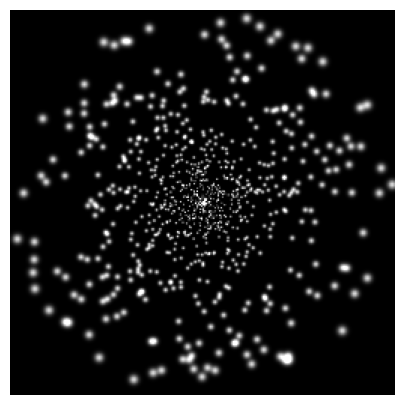

In [3]:
# Stimulation amplitude
amplitude = 160.e-6 # Ampère (default 100µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

plt.figure(figsize=(5,5))

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Perceived Uniformity

In [4]:
def measure_electrode_brightness_varying(
    phos_image, phos_x, phos_y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
):
    """
    For each electrode (x_i,y_i), measure brightness in `phos_image` around
    a patch whose size depends on radial distance from `center`.

    Args:
      phos_image : 2D array from the simulator (H,W), can be torch or np
      phos_x, phos_y : arrays of length N
      x_min,x_max,y_min,y_max : bounding coords to map to pixel indices
      base_size : minimal half-size of patch (like 'radius' in pixel terms)
      scale     : how much to increase the patch size per unit distance
      center    : define (cx, cy), the 'center' for radial distance

    Returns:
      brightness : 1D array of length N
    """
    # Convert to numpy if it's torch
    if isinstance(phos_image, torch.Tensor):
        phos_image = phos_image.cpu().numpy()

    H, W = phos_image.shape
    N = len(phos_x)
    brightness = np.zeros(N, dtype=float)

    cx, cy = center

    def to_pixel_coords(x, y):
        px = (x - x_min)/(x_max - x_min)*(W-1)
        py = (y - y_min)/(y_max - y_min)*(H-1)
        return int(round(px)), int(round(py))

    for i in range(N):
        # radial distance from center
        rx = phos_x[i] - cx
        ry = phos_y[i] - cy
        r_i = np.sqrt(rx*rx + ry*ry)

        # dynamic half-size of patch
        half_n = int(round(base_size + scale*r_i))
        # avoid half_n=0 if r_i=0
        half_n = max(half_n, 1)

        px, py = to_pixel_coords(phos_x[i], phos_y[i])

        vals = []
        for dx in range(-half_n, half_n+1):
            for dy in range(-half_n, half_n+1):
                qx = px + dx
                qy = py + dy
                if 0 <= qx < W and 0 <= qy < H:
                    vals.append(phos_image[qy, qx])  # (row, col) => (y, x)

        if len(vals) > 0:
            brightness[i] = np.mean(vals)
        else:
            brightness[i] = 0.0

    return brightness

def iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init,
    steps=5,
    base_size=1,
    scale=0.05,
    center=(0,0),
    A_min=1e-7,
    A_max=1e-3,
    learning_rate=0.5,
    target=None
):
    """
    Iteratively normalizes electrode amplitudes using a varying patch size
    to measure brightness in the outer region more generously.

    We'll reuse the partial update + clamping approach from before.
    """
    stim = stim_init.clone()
    N = len(phos_x)

    for step in range(steps):
        simulator.reset()
        phos_img = simulator(stim)
        # measure brightness with dynamic patch size
        b = measure_electrode_brightness_varying(
            phos_img, phos_x, phos_y,
            x_min=-8.0, x_max=8.0,
            y_min=-8.0, y_max=8.0,
            base_size=base_size,
            scale=scale,
            center=center
        )
        # define target
        if target is None:
            nonzero = b[b>1e-12]
            T = np.mean(nonzero) if len(nonzero)>0 else 1.0
        else:
            T = target

        updated = []
        for i in range(N):
            oldA = stim[i].item()
            meas = b[i]
            if meas < 1e-12:
                # small brightness => partial bump
                newA = oldA*1.1
            else:
                ratio = T/meas
                # partial update
                newA = oldA*(1.0 + learning_rate*(ratio - 1.0))

            # clamp
            if newA < A_min:
                newA = A_min
            elif newA > A_max:
                newA = A_max

            updated.append(newA)

        stim = torch.tensor(updated, device=stim.device, dtype=stim.dtype)

    return stim


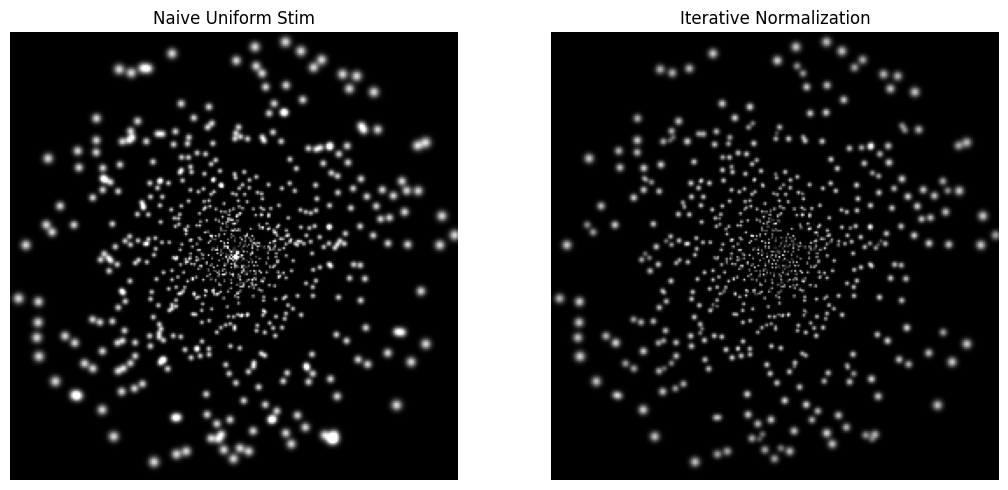

Final amplitude: min=4.35e-05, max=1.60e-04


In [5]:
phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
N = len(phos_x)

stim_uniform = amplitude * torch.ones(N, device='cuda')
simulator.reset()
phos_naive = simulator(stim_uniform)

# iterative approach with dynamic patch
stim_final = iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init=stim_uniform,
    steps=50,
    base_size=1,
    scale=0.5,
    center=(0,0),
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    target=None  # auto-averaging
)

simulator.reset()
phos_final = simulator(stim_final)

plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.title("Naive Uniform Stim")
plt.imshow(phos_naive.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Iterative Normalization")
plt.imshow(phos_final.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Final amplitude: min={stim_final.min():.2e}, max={stim_final.max():.2e}")

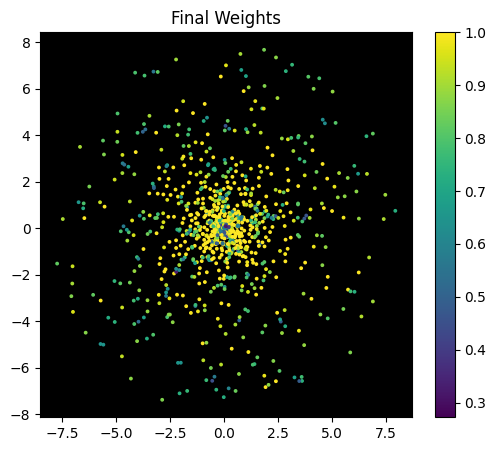

In [6]:
stim_weights = stim_final/amplitude

# show the stim_final values on the phosphene_coords locations
plt.figure(figsize=(6,5))
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=to_numpy(stim_weights), cmap='viridis', s=3)
plt.colorbar()
plt.title("Final Weights")
# black background
plt.gca().set_facecolor('black')
# plt.axis('off')
plt.show()

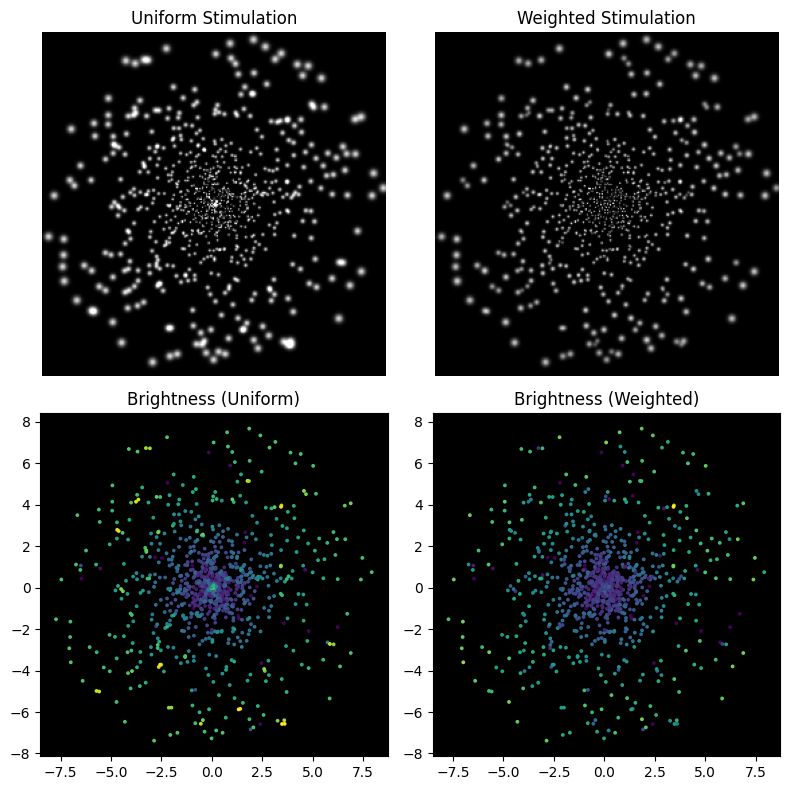

New stimulation: 83.99% of original amplitude


In [7]:
# test stim_weights
simulator.reset()
uniform_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude
phos_uniform = simulator(uniform_stimulation_sequence.cuda())

simulator.reset()
weighted_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude*stim_weights
phos_weighted = simulator(weighted_stimulation_sequence.cuda())

# measure brightness for uniform and weighted stim
brightness_uniform = measure_electrode_brightness_varying(
    phos_uniform, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

brightness_weighted = measure_electrode_brightness_varying(
    phos_weighted, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

# Plot the Uniform vs Weighted stimulation and the corresponding brightness in a 2 x 2 plot
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("Uniform Stimulation")
plt.imshow(phos_uniform.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Weighted Stimulation")
plt.imshow(phos_weighted.cpu().numpy(), cmap='gray')
plt.axis('off')

# scatterplot of brightness for uniform vs weighted stim on the phosphene coords
plt.subplot(2,2,3)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_uniform, cmap='viridis', s=3)
plt.title("Brightness (Uniform)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.subplot(2,2,4)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_weighted, cmap='viridis', s=3)
plt.title("Brightness (Weighted)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.tight_layout()
plt.show()

# print the mean in percentages of the final weights
print(f"New stimulation: {100*stim_weights.mean():.2f}% of original amplitude")

# Patterns

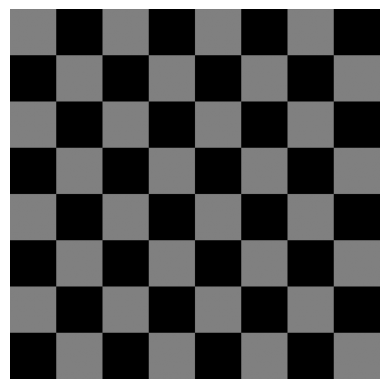

In [8]:
def checkerboard_generator(bandwidth=32, stim_size=(256,256), dark_value=0.0, light_value=0.5, offset_x=0, offset_y=0):
    """
    Generate a checkerboard pattern
    """
    # Create a checkerboard pattern
    checkerboard = np.zeros(stim_size) + dark_value
    for i in range(stim_size[0]):
        for j in range(stim_size[1]):
            if (i//bandwidth + j//bandwidth) % 2 == 0:
                checkerboard[i,j] = light_value

    # Shift the checkerboard
    checkerboard = np.roll(checkerboard, offset_x, axis=1)
    checkerboard = np.roll(checkerboard, offset_y, axis=0)

    return checkerboard

checkerboard = checkerboard_generator()

# show
plt.imshow(checkerboard, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

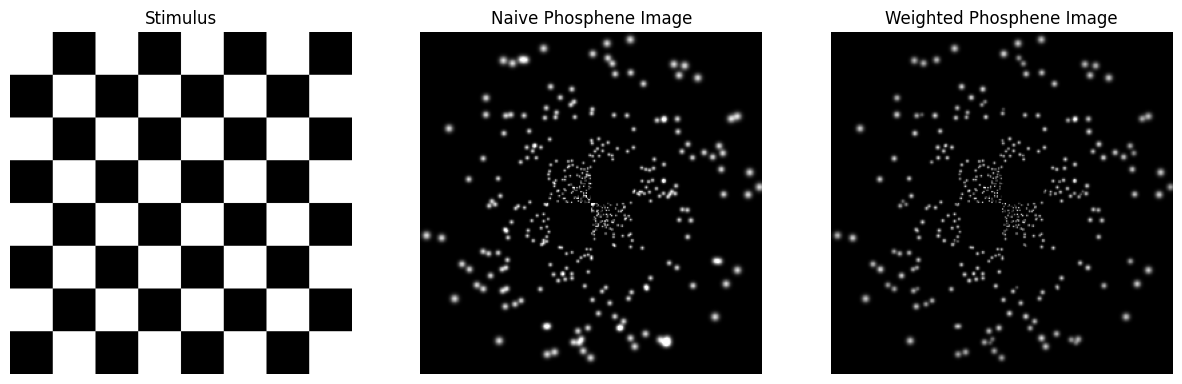

In [9]:
# Generate a checkerboard pattern
checkerboard = checkerboard_generator(bandwidth=32, dark_value=0.0, light_value=1.0)

stim = torch.tensor(checkerboard).float().cuda()

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stim, rescale=True))

simulator.reset()
phosphenes_weighted = simulator(simulator.sample_stimulus(stim, rescale=True)*stim_weights)

# Plot the stimulus, the naive phosphene image and the weighted phosphene image
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(stim.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Stimulus")

plt.subplot(1,3,2)
plt.imshow(phosphenes.cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Naive Phosphene Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes_weighted.cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Weighted Phosphene Image")

plt.show()


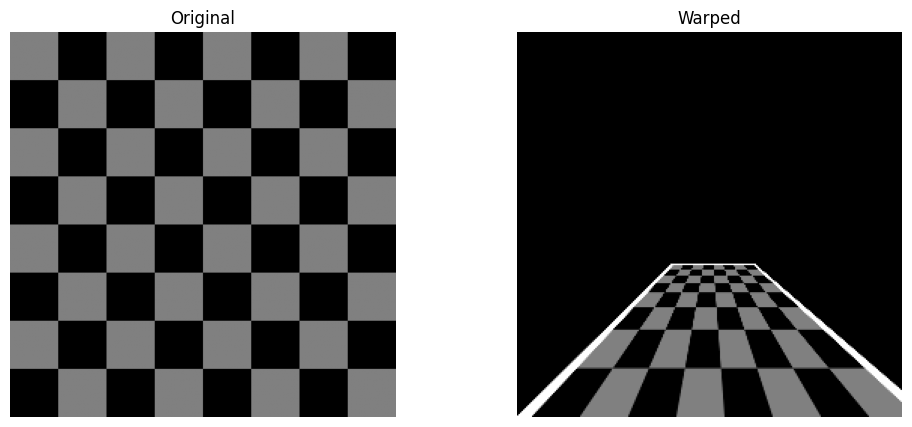

In [10]:
def warp_image(checkerboard, vanishing_point=(0.4, 0.4), skew=0.0, border=10):
    # Suppose `checkerboard` is your original image, shape [H, W].
    # For demonstration, let's assume it’s a grayscale numpy array.

    # 1) Get the dimensions
    rows, cols = checkerboard.shape[:2]

    # 2) Define the 4 corner points of the original image.
    #    Typically: (top-left, top-right, bottom-left, bottom-right)
    src_points = np.float32([
        [0,       0],
        [cols-1,  0],
        [0,       rows-1],
        [cols-1,  rows-1]
    ])

    # 3) Define where you want these corners to map in the "warped" image.
    #    By moving the top corners closer together, you get a vanishing effect.
    #    For example, push the top-left corner and top-right corner inward 
    #    so they converge. The bottom corners might remain at the full width.

    # Define the vanishing point
    vp_x, vp_y = vanishing_point

    # Define the destination points based on the vanishing point
    dst_points = np.float32([
        [cols*vp_x+skew, rows*vp_y],
        [cols*(1-vp_x)+skew, rows*vp_y],
        [0, rows-1],
        [cols-1, rows-1]
    ])

    # 4) Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # make the border of the checkerboard white
    checkerboard = cv2.copyMakeBorder(checkerboard, border, border, border, border, cv2.BORDER_CONSTANT, value=1)

    # 5) Apply the transform
    warped = cv2.warpPerspective(checkerboard, M, (cols, rows))
    return warped


checkerboard = checkerboard_generator(bandwidth=32, dark_value=0.0, light_value=0.5)
warped = warp_image(checkerboard, vanishing_point=(0.4, 0.6), skew=0)

# 6) Visualize
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Original")
plt.imshow(checkerboard, cmap='gray', vmin=0, vmax=1); plt.axis('off')

plt.subplot(1,2,2); plt.title("Warped")
plt.imshow(warped, cmap='gray', vmin=0, vmax=1); plt.axis('off')
plt.show()


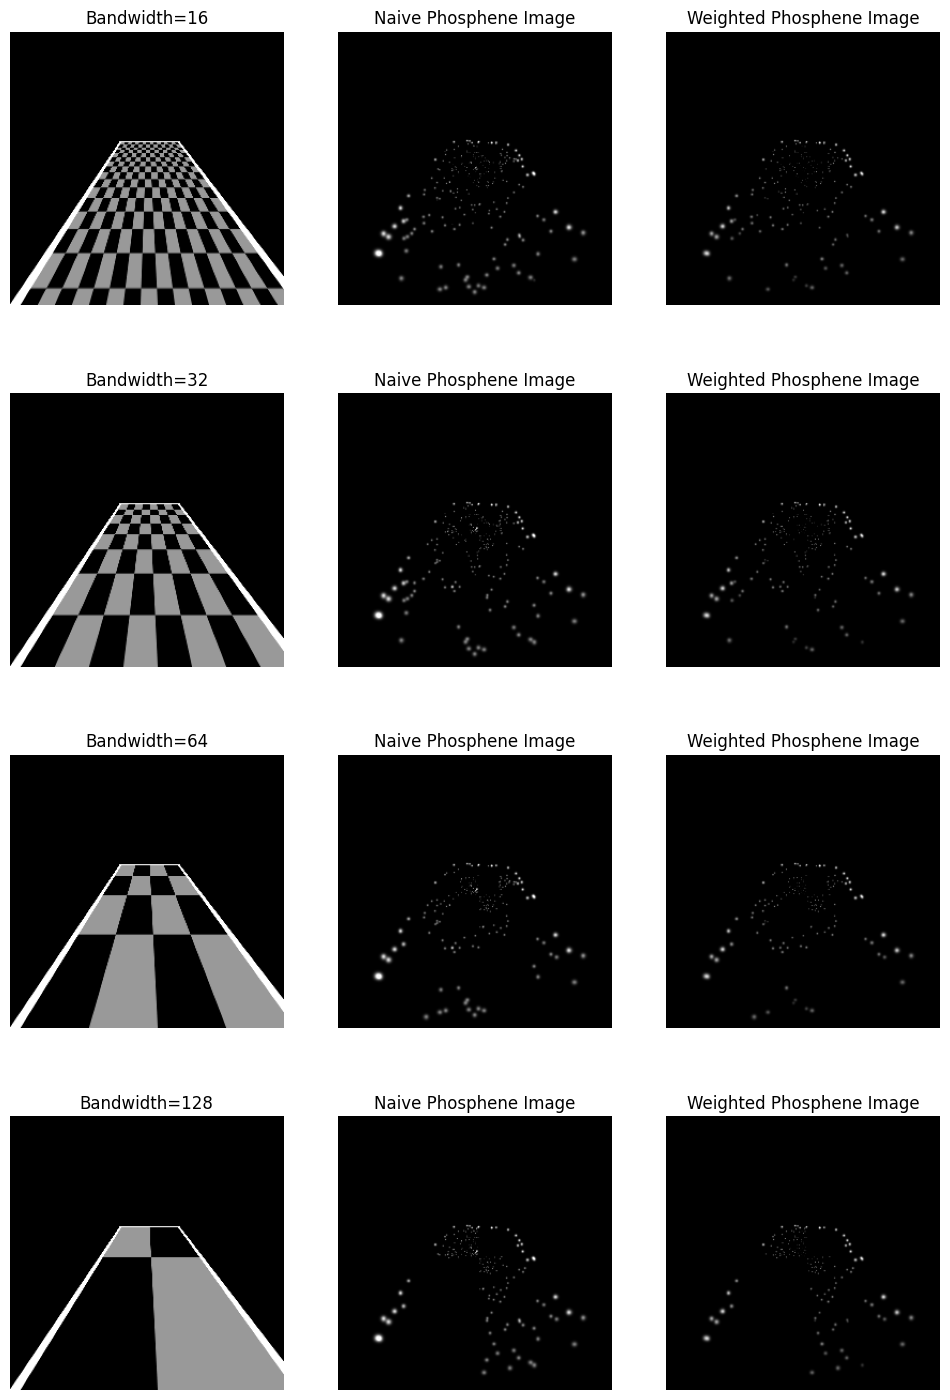

In [11]:
# test for different settings:
# 1) Different bandwidth: 16, 32, 64, 128
# Show Stimiulus with vmin=0, vmax=1, then naive phosphenes and then weighted phosphenes

plt.figure(figsize=(12,18))
for i, bandwidth in enumerate([16, 32, 64, 128]):
    checkerboard = checkerboard_generator(bandwidth=bandwidth, dark_value=0.0, light_value=0.6)
    warped = warp_image(checkerboard)
    stim = torch.tensor(warped).float().cuda()

    # Reset and call the simulator
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stim, rescale=True))

    simulator.reset()
    phosphenes_weighted = simulator(simulator.sample_stimulus(stim, rescale=True)*stim_weights)

    plt.subplot(4,3,3*i+1)
    plt.imshow(stim.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f"Bandwidth={bandwidth}")

    plt.subplot(4,3,3*i+2)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    # title
    plt.title("Naive Phosphene Image")

    plt.subplot(4,3,3*i+3)
    plt.imshow(phosphenes_weighted.cpu(), cmap='gray')
    plt.axis('off')
    # title
    plt.title("Weighted Phosphene Image")

plt.show()

In [12]:
def plot_checkerboard(bandwidth=64, dark_value=0.0, light_value=1.0, border=10, vp_x=0.4, vp_y=0.4, skew=0.0, offset_x=0, offset_y=0, weighted=True):
    checkerboard = checkerboard_generator(bandwidth=bandwidth, dark_value=dark_value, light_value=light_value, offset_x=offset_x, offset_y=offset_y)
    warped = warp_image(checkerboard, vanishing_point=(vp_x, vp_y), skew=skew, border=border)
    stim = torch.tensor(warped).float().cuda()
    sample_stim = simulator.sample_stimulus(stim, rescale=True)
    if weighted:
        sample_stim = sample_stim*stim_weights

    simulator.reset()
    phosphenes = simulator(sample_stim)

    plt.figure(figsize=(12,7))

    plt.subplot(1,2,1)
    plt.imshow(stim.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title("Stimulus")

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()   

_ = interact(plot_checkerboard, bandwidth=(16, 128, 1), dark_value=(0, 1, 0.01), light_value=(0, 1, 0.01), border=(0, 20, 1),
              vp_x=(0, 0.48, 0.01), vp_y=(0, 0.9, 0.01), skew=(-100, 100, 1), offset_x=(-256, 256, 1), offset_y=(-256, 256, 1), weighted=True)

interactive(children=(IntSlider(value=64, description='bandwidth', max=128, min=16), FloatSlider(value=0.0, de…

# Candidate patterns

## Gabor

In [13]:
def gabor_generator(
    size=256, freq=3, theta=0, sigma=2, offset=0.0
):
    """
    Generate a Gabor pattern

    Args:
        size : size of the image
        freq : frequency of the cosine wave
        theta : orientation of the Gabor
        sigma : standard deviation of the Gaussian envelope
        offset : offset value for the Gabor
    """
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    Xp = X*np.cos(theta) + Y*np.sin(theta)
    Yp = -X*np.sin(theta) + Y*np.cos(theta)
    gabor = np.exp(-0.5*(Xp**2 + Yp**2)/sigma**2)*np.cos(2*np.pi*freq*Xp) + offset
    return gabor

In [14]:
# Gabor kernel and phosphene image interactive plot
def plot_gabor(freq=2, theta=np.pi/2, sigma=0.3, offset=0.5, weighted=True):
    gabor = gabor_generator(freq=freq, theta=theta, sigma=sigma, offset=offset)
    stim = torch.tensor(gabor).float().cuda()
    sample_stim = simulator.sample_stimulus(stim, rescale=True)
    if weighted:
        sample_stim = sample_stim*stim_weights

    simulator.reset()
    phosphenes = simulator(sample_stim)

    plt.figure(figsize=(12,7))

    plt.subplot(1,2,1)
    plt.imshow(stim.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Stimulus")

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_gabor, freq=(0.1, 50, 0.1), theta=(0, np.pi, np.pi/8), sigma=(0.1, 1, 0.1), offset=(0, 1, 0.1), weighted=True)

interactive(children=(FloatSlider(value=2.0, description='freq', max=50.0, min=0.1), FloatSlider(value=1.57079…

In [15]:
# Interactive plot for the Gabor pattern

def plot_gabor(theta=0, freq=2, sigma=2, offset=0.5, vp_x=0.4, vp_y=0.4, skew=0.0, weighted=True):
    gabor = gabor_generator(theta=theta, freq=freq, sigma=sigma, offset=offset)
    warped_gabor = warp_image(gabor, vanishing_point=(vp_x, vp_y), skew=skew)
    gabor_stim = torch.tensor(warped_gabor).float().cuda()
    sample_stim = simulator.sample_stimulus(gabor_stim, rescale=True)
    if weighted:
        sample_stim = sample_stim*stim_weights

    simulator.reset()
    phosphenes = simulator(sample_stim)

    plt.figure(figsize=(12,7))

    plt.subplot(1,2,1)
    plt.imshow(warped_gabor, cmap='gray')
    plt.axis('off')
    plt.title("Gabor Stimulus")

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_gabor, theta=(0, np.pi, 0.1), freq=(1, 10, 0.1), sigma=(0.1, 5, 0.1), offset=(0, 1, 0.1), vp_x=(0, 0.48, 0.01), vp_y=(0, 0.9, 0.01), skew=(-100, 100, 1), weighted=True)


interactive(children=(FloatSlider(value=0.0, description='theta', max=3.141592653589793), FloatSlider(value=2.…

# Voronoi diagram

<Figure size 900x900 with 0 Axes>

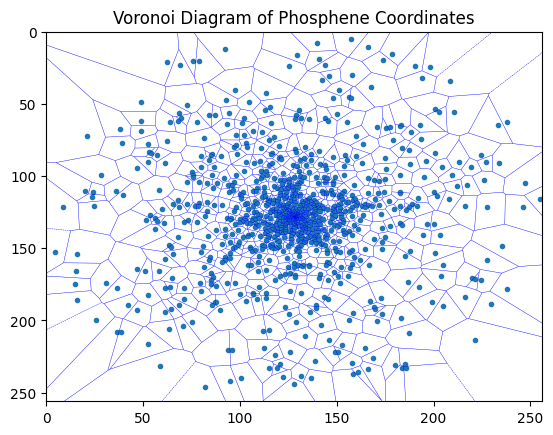

In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Map phos_x and phos_y to the 256 x 256 image space given that the view angle is 16 degrees
phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
phos_x = (phos_x + 8) * 256/16
phos_y = (phos_y + 8) * 256/16
coords = np.column_stack((phos_x, phos_y))

# Compute Voronoi diagram
vor = Voronoi(coords)

# Plot the Voronoi diagram
plt.figure(figsize=(9, 9))
voronoi_plot_2d(vor, show_vertices=False, line_colors='blue', line_width=0.3, show_points=True)
# min and max x and y are 0 and 256
plt.xlim(0, 256)
plt.ylim(0, 256)
plt.gca().invert_yaxis()  # Invert y-axis to match image space
plt.title('Voronoi Diagram of Phosphene Coordinates')
plt.show()

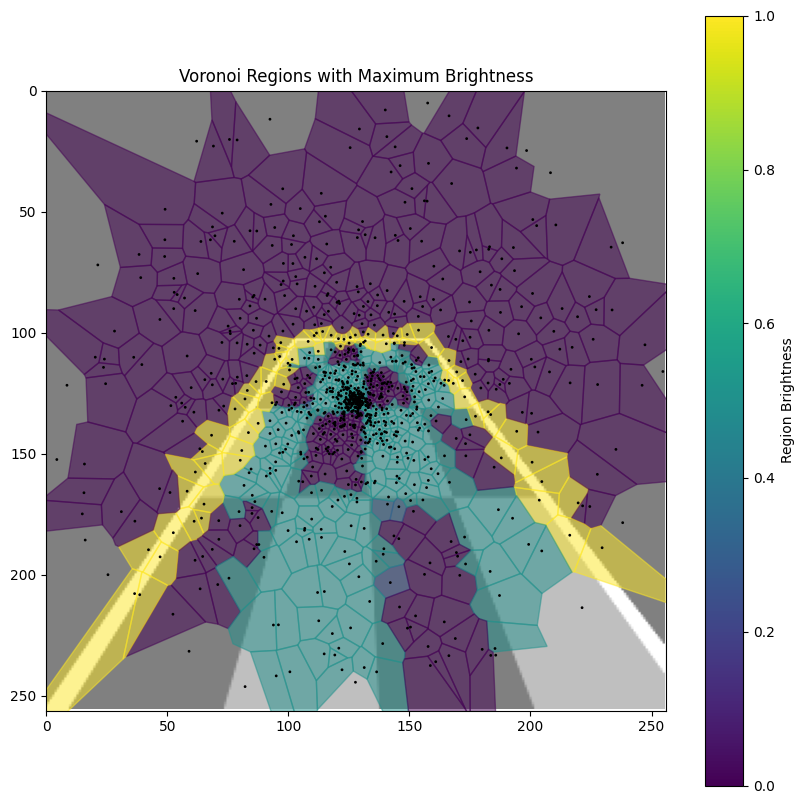

In [17]:
# try with the warped checkerboard from earlier
# Assuming `coords`, `warped`, and `vor` are defined
# Initialize an array to store maximum brightness per region

checkerboard = checkerboard_generator(bandwidth=64, dark_value=0.0, light_value=0.5)
warped = warp_image(checkerboard, vanishing_point=(0.4, 0.4), skew=0)

region_brightness = np.zeros(len(vor.points))

# Iterate through regions
for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        # Skip regions that are unbounded
        continue
    
    # Get the vertices of the polygon
    polygon = [vor.vertices[v] for v in region]

    # Create a mask for this region
    mask = np.zeros_like(warped, dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32)], 1)

    # Calculate the maximum brightness in the region
    region_brightness[i] = np.max(warped[mask == 1])

# Plot Voronoi diagram with brightness information
plt.figure(figsize=(10, 10))
plt.imshow(warped, cmap='gray', alpha=0.5)  # Show the original image in the background

for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        continue
    polygon = [vor.vertices[v] for v in region]
    
    # Use the brightness value to determine the color of the region
    brightness = region_brightness[i]
    plt.fill(*zip(*polygon), color=plt.cm.viridis(brightness), alpha=0.5)

# Scatter the Voronoi points with brightness values
plt.scatter(coords[:, 0], coords[:, 1], c=region_brightness, cmap='viridis', edgecolor='k', s=1)

# Set plot limits and colorbar
plt.xlim(0, 256)
plt.ylim(0, 256)
plt.colorbar(label='Region Brightness', cmap='viridis')

plt.title('Voronoi Regions with Maximum Brightness')
plt.gca().invert_yaxis()  # Invert the y-axis to match image orientation



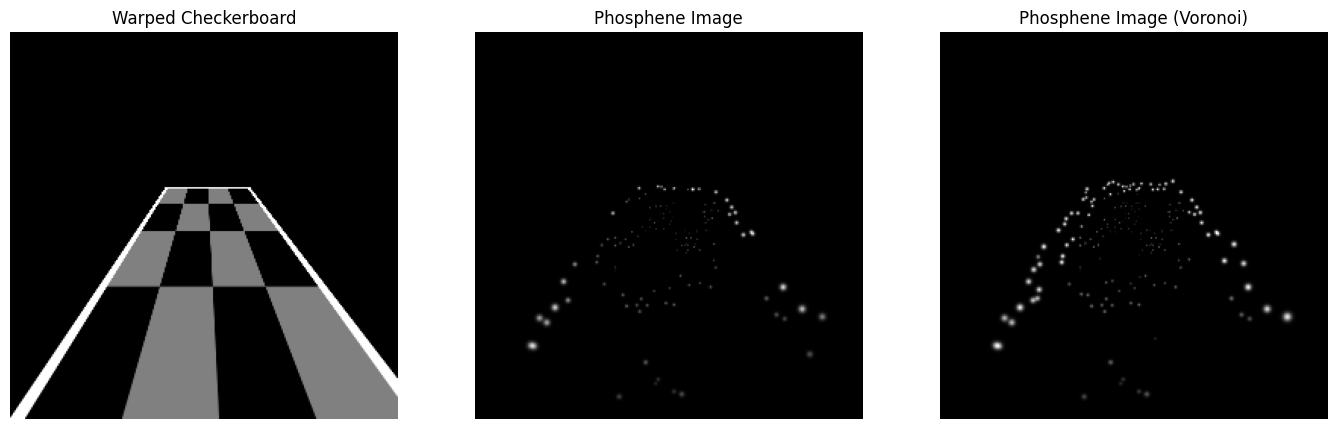

In [18]:
# show the phosphene image
stimulus = torch.tensor(region_brightness).float().cuda()*amplitude*stim_weights

simulator.reset()

phosphenes_voronoi = simulator(stimulus)

# compare to the checkerboard from earlier

simulator.reset()

phosphenes_checkerboard = simulator(simulator.sample_stimulus(torch.tensor(warped).float().cuda(), rescale=True)*stim_weights)


plt.figure(figsize=(17,7))

plt.subplot(1,3,1)
plt.imshow(warped, cmap='gray')
plt.axis('off')
plt.title("Warped Checkerboard")

plt.subplot(1,3,2)
plt.imshow(phosphenes_checkerboard.cpu(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")
 
plt.subplot(1,3,3)
plt.imshow(phosphenes_voronoi.cpu(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image (Voronoi)")

plt.show()

# Foveation

In [19]:
from components.fov_conv2d_cont import FovConv2dCont

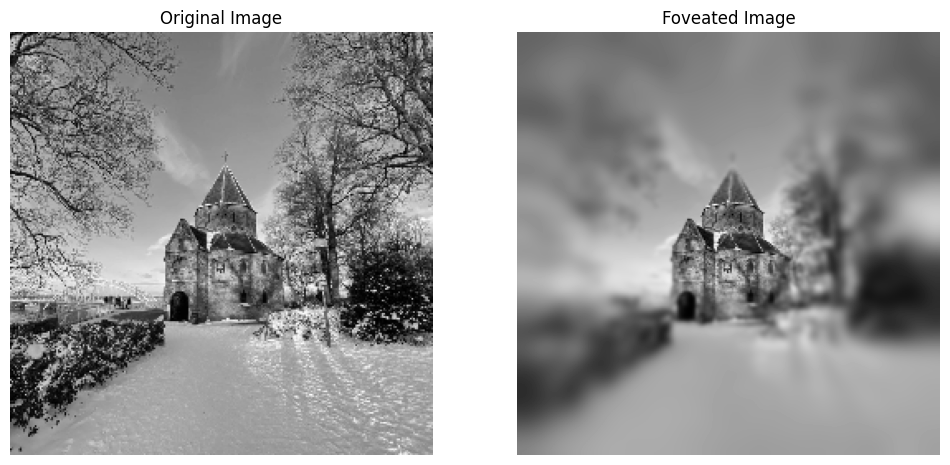

In [20]:
# open image valkhof.jpg

# Load the image
image = cv2.imread('valkhof.jpg', cv2.IMREAD_GRAYSCALE)
# crop image to be square
# get the dimensions
h, w = image.shape
# calculate the crop size
crop_size = min(h, w)
# calculate the starting point
start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
# crop the image
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

in_channels = 1
out_channels = 1
kernel_size = 1
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='gaussian_modulated',
                    gaussian_kernel_size=51, sigma_min=0.0001, sigma_max=15, sigma_function='exponential', contrast_factor=1, padding_mode='reflect').cuda()

# center of the image foa_xy
foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)
torch_image = torch.tensor(image).float().cuda().unsqueeze(0).unsqueeze(0)
out = net(torch_image, foa_xy)

foveated_image = out[0][0].detach().cpu().numpy()
# normalize between 0 and 1 
foveated_image = (foveated_image - foveated_image.min()) / (foveated_image.max() - foveated_image.min())

# Show the foveated image
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(foveated_image, cmap='gray')
plt.axis('off')
plt.title("Foveated Image")

plt.show()


In [21]:
# interactive plot for the foveated image: sigma_min, sigma_max, contrast_factor, weighted
# show the foveated image and the laplacian image

def laplacian(img):
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return cv2.filter2D(img, cv2.CV_32F, laplacian_kernel)

def plot_foveated_image(sigma_min=0.0001, sigma_max=6, contrast_factor=1, weighted=True):
    net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='gaussian_modulated',
                    gaussian_kernel_size=7, sigma_min=sigma_min, sigma_max=sigma_max, sigma_function='exponential', contrast_factor=contrast_factor).cuda()

    out = net(torch_image, foa_xy)

    foveated_image = out[0][0].detach().cpu().numpy()
    foveated_image = (foveated_image - foveated_image.min()) / (foveated_image.max() - foveated_image.min())

    laplacian_image = np.abs(laplacian((foveated_image*255).astype(np.uint8))/255)

    # phosphene image 
    simulator.reset()
    stimulus = simulator.sample_stimulus(torch.tensor(laplacian_image).float().cuda(), rescale=True)
    if weighted:
        stimulus = stimulus*stim_weights
    phosphenes = simulator(stimulus)
    

    plt.figure(figsize=(15,7))

    plt.subplot(1,3,1)
    plt.imshow(foveated_image, cmap='gray')
    plt.axis('off')
    plt.title("Foveated Image")

    plt.subplot(1,3,2)
    plt.imshow(np.abs(laplacian_image), cmap='gray')
    plt.axis('off')
    plt.title("Laplacian Image")

    plt.subplot(1,3,3)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_foveated_image, sigma_min=(0.0001, 6, 0.0001), sigma_max=(1, 10, 0.1), contrast_factor=(1, 100, 1), threshold=(-0.2, 0.2, 0.0001), weighted=True)


interactive(children=(FloatSlider(value=0.0001, description='sigma_min', max=6.0, min=0.0001, step=0.0001), Fl…

In [22]:
# interactive plot for one gabor. plot the input image, the gabor kernel, the response and the phosphene image

def plot_gabor_response(kernel_size=47, freq=1, theta=np.pi/2, sigma=0.35, weighted=True):
    gabor = gabor_generator(size=kernel_size, freq=freq, theta=theta, sigma=sigma)
    response = cv2.filter2D(foveated_image, -1, gabor)
    response = np.abs(response)
    response = cv2.normalize(response, None, 0, 1, cv2.NORM_MINMAX)

    # phosphene image 
    simulator.reset()
    stimulus = simulator.sample_stimulus(torch.tensor(response).float().cuda(), rescale=True)
    if weighted:
        stimulus = stimulus*stim_weights
    phosphenes = simulator(stimulus)

    plt.figure(figsize=(19,7))

    plt.subplot(1,4,1)
    plt.imshow(foveated_image, cmap='gray')
    plt.axis('off')
    plt.title("Foveated Image")

    plt.subplot(1,4,2)
    plt.imshow(gabor, cmap='gray')
    plt.axis('off')
    plt.title("Gabor Kernel")

    plt.subplot(1,4,3)
    plt.imshow(response, cmap='gray')
    plt.axis('off')
    plt.title("Response")

    plt.subplot(1,4,4)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_gabor_response, kernel_size=(3, 99, 2), freq=(0.1, 10, 0.01), theta=(0, np.pi, np.pi/8), sigma=(0.1, 2, 0.01), weighted=True)

interactive(children=(IntSlider(value=47, description='kernel_size', max=99, min=3, step=2), FloatSlider(value…

# Multi Frequency Response

## Nyquist Frequencies for Phosphene Vision

The **Nyquist frequency** defines the highest spatial frequency that can be accurately resolved, based on the spatial arrangement of electrodes. For each electrode \( e \), it is calculated as:

$ f_{\text{Nyquist}, e} = \frac{1}{2d_e} $

where:
- $ d_e $: The average distance from electrode $ e $ to its nearest neighbors.

### Calculation Steps:
1. **Electrode Layout:** Identify spatial positions of all electrodes.
2. **Neighbor Detection:** Use Delaunay triangulation or Voronoi diagrams to find neighbors.
3. **Average Distance:** Compute:
   $
   d_e = \frac{1}{N} \sum_{i=1}^N d_{i, e}
   $
   where $N$ is the number of neighbors.
4. **Nyquist Frequency:** Calculate:
   $
   f_{\text{Nyquist}, e} = \frac{1}{2d_e}
   $

This frequency map aligns spatial detail with the electrode arrangement, guiding feature extraction methods tailored to the phosphene layout.


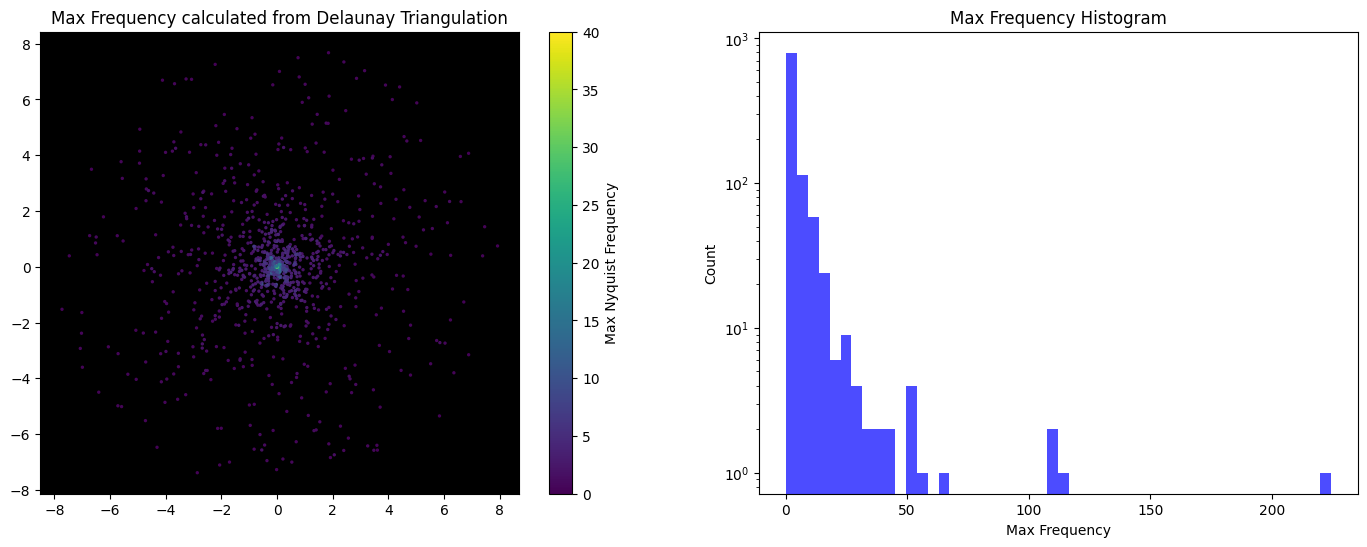

Mean Max Frequency: 4.62
Min Max Frequency (20th percentile): 0.81
Max Max Frequency (97th percentile): 20.04


In [23]:
from scipy.spatial import Delaunay
import numpy as np

# Example: phosphene_coords is a Nx2 array with [x, y] positions
phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
coords = np.column_stack((phos_x, phos_y))

tri = Delaunay(coords)
neighbors = tri.vertex_neighbor_vertices
avg_distances = []

for i in range(len(coords)):
    start, end = neighbors[0][i], neighbors[0][i+1]
    neighbor_indices = neighbors[1][start:end]
    distances = np.linalg.norm(coords[i] - coords[neighbor_indices], axis=1)
    avg_distances.append(np.mean(distances))

avg_distances = np.array(avg_distances)
max_frequencies = 1 / (2 * avg_distances)  # Nyquist frequency

# show the max frequencies in a scatter plot and in a histogram

plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
# make the max frequencies log scale
plt.scatter(phos_x, -phos_y, c=max_frequencies, cmap='viridis', s=2, vmin=0, vmax=40)
plt.colorbar(label='Max Nyquist Frequency')
plt.title("Max Frequency calculated from Delaunay Triangulation")
plt.gca().set_facecolor('black')

plt.subplot(1,2,2)
plt.hist(max_frequencies, bins=50, color='blue', alpha=0.7)
plt.title("Max Frequency Histogram")
plt.xlabel("Max Frequency")
plt.ylabel("Count")
# log scale
plt.yscale('log')

plt.show()

# take the ... percentile for mean max and min
mean_max_frequency = np.mean(max_frequencies)
min_max_frequency = np.percentile(max_frequencies, 20)
max_max_frequency = np.percentile(max_frequencies, 97)

print(f"Mean Max Frequency: {mean_max_frequency:.2f}")
print(f"Min Max Frequency ({20}th percentile): {min_max_frequency:.2f}")
print(f"Max Max Frequency ({97}th percentile): {max_max_frequency:.2f}")

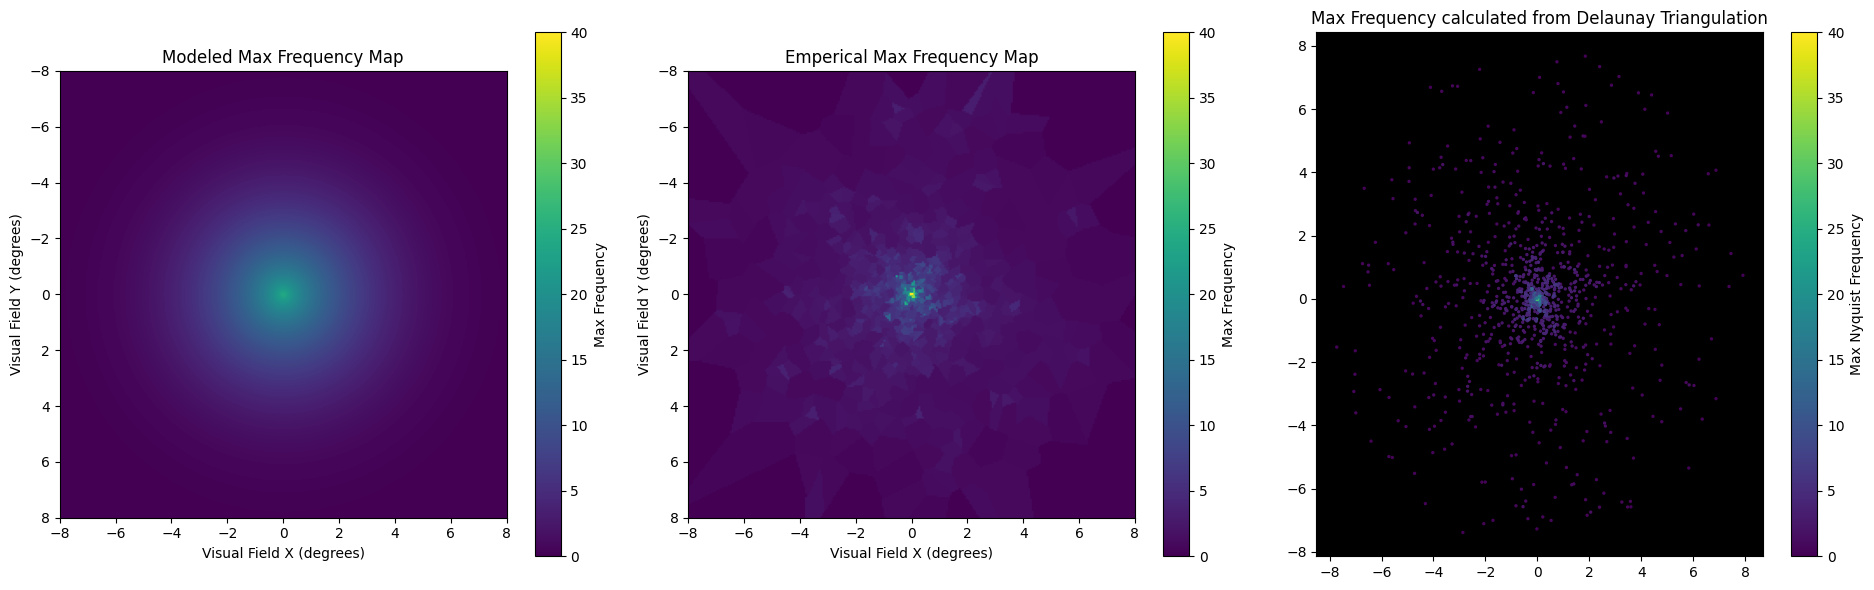

1024.0000000000002

In [24]:
# Convert from visual field degrees to pixel space
range_deg = 8  # Assume the visual field is -8 to 8 degrees
image_size = 256

# Map visual field coordinates to pixel space
pixel_coords = (coords + range_deg) / (2 * range_deg) * image_size

# Create a 256x256 frequency map
max_frequencies_map_2d = np.zeros((image_size, image_size))

# Fill the map using the Voronoi regions
for region_index in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[region_index]]
    if -1 in region or len(region) == 0:
        continue
    
    polygon = [vor.vertices[v] for v in region]
    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32)], 1)

    # Assign max frequency value to the region
    max_frequency = max_frequencies[region_index]
    max_frequencies_map_2d[mask == 1] = max_frequency

max_frequencies_map_2d *= 2

# Define parameters
total_phosphenes = n_phosphenes
image_size = 256
view_angle = 16  # in degrees
max_eccentricity = view_angle / 2

# Define cortical magnification model parameters
cortex_model_params = {
    "model": "dipole",
    "k": 17.3,
    "a": 0.75,
    "b": 120,
}

# Gaussian distribution parameters for phosphene placement
gaussian_center = 0  # Center of the distribution
gaussian_std = 2  # Standard deviation of the Gaussian

def get_cortical_magnification(r, params):
    """
    Calculate cortical magnification based on the model and parameters.
    """
    mapping_model = params['model']
    a = params['a']
    b = params['b']
    k = params['k']
    if mapping_model == 'monopole':
        return k / (r + a)
    elif mapping_model in ['dipole', 'wedge-dipole']:
        return k * (1 / (r + a) - 1 / (r + b))
    else:
        raise NotImplementedError("Unsupported cortical magnification model.")

def calculate_phosphene_density(r, params, total_phosphenes, view_angle):
    """
    Calculate phosphene density based on Gaussian distribution and cortical magnification.
    """
    # Gaussian distribution (radial)
    gaussian_density = np.exp(-0.5 * (r / gaussian_std) ** 2)

    # Cortical magnification
    cortical_magnification = get_cortical_magnification(r, params)

    # Combine densities
    combined_density = gaussian_density * cortical_magnification

    # Integrate over the visual field area to scale correctly
    visual_field_area = np.pi * (view_angle / 2) ** 2  # Total area of the visual field
    integrated_density = np.sum(combined_density) * (view_angle / image_size) ** 2

    # Scale to match the total number of phosphenes
    scaled_density = combined_density * (total_phosphenes / integrated_density)

    return scaled_density

def calculate_max_frequency_with_density(density_map):
    """
    Calculate the maximum frequency map based on the phosphene density.
    """
    return np.sqrt(density_map)*2  # Nyquist frequency proportional to sqrt(density)

# Create a 2D grid of eccentricities
x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)  # Eccentricity

# Calculate phosphene density and frequency map
phosphene_density_map = calculate_phosphene_density(r, cortex_model_params, total_phosphenes, view_angle)
modeled_max_frequency_map = calculate_max_frequency_with_density(phosphene_density_map)

# Plot the modeled density and frequency maps
plt.figure(figsize=(19, 6))

# Plot modeled max frequency map
plt.subplot(1, 3, 1)
plt.imshow(modeled_max_frequency_map, extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity),
           cmap='viridis', vmin=0, vmax=40)
plt.colorbar(label='Max Frequency')
plt.title("Modeled Max Frequency Map")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()

# emperical max_frequencies_map_2d
plt.subplot(1, 3, 2)
plt.imshow(max_frequencies_map_2d, extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity),
           cmap='viridis', vmin=0, vmax=40)
plt.colorbar(label='Max Frequency')
plt.title("Emperical Max Frequency Map")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()

# scatter plot
plt.subplot(1, 3, 3)
plt.scatter(phos_x, -phos_y, c=max_frequencies, cmap='viridis', s=2, vmin=0, vmax=40)
plt.colorbar(label='Max Nyquist Frequency')
plt.title("Max Frequency calculated from Delaunay Triangulation")
plt.gca().set_facecolor('black')

plt.tight_layout()
plt.show()

# Total phosphenes from the density map
total_modeled_phosphenes = np.sum(phosphene_density_map) * (view_angle / image_size) ** 2
total_modeled_phosphenes


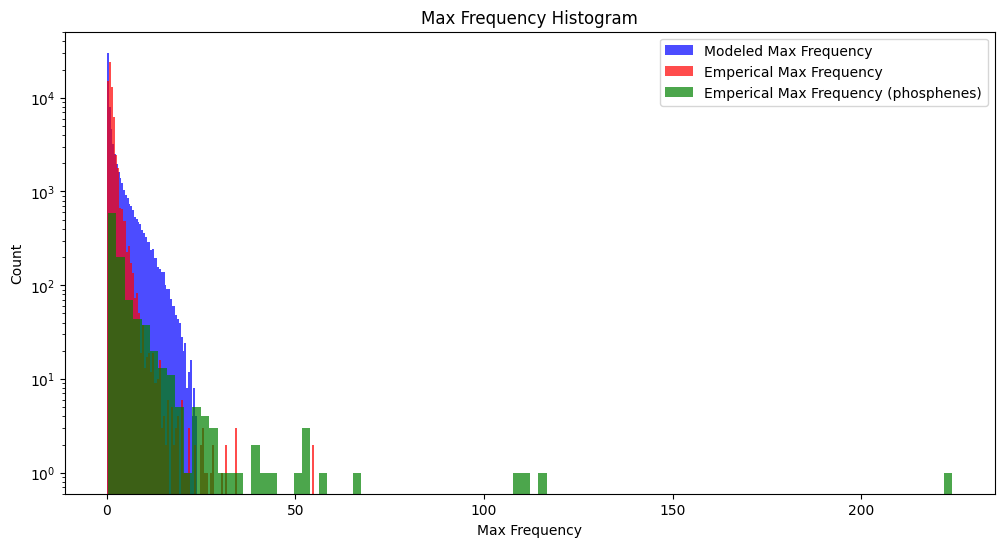

In [25]:
# histograms of the modeled and emperical max frequencies
plt.figure(figsize=(12, 6))

plt.hist(modeled_max_frequency_map.flatten(), bins=50, color='blue', alpha=0.7, label='Modeled Max Frequency')
plt.hist(max_frequencies_map_2d.flatten(), bins=100, color='red', alpha=0.7, label='Emperical Max Frequency')
plt.hist(max_frequencies.flatten(), bins=100, color='green', alpha=0.7, label='Emperical Max Frequency (phosphenes)')
plt.title("Max Frequency Histogram")
plt.xlabel("Max Frequency")
plt.ylabel("Count")
plt.yscale('log')
plt.legend()

plt.show()

In [26]:
# take the ... percentile for mean max and min
mean_max_frequency = np.mean(max_frequencies)
min_max_frequency = np.percentile(max_frequencies, 20)
max_max_frequency = np.percentile(max_frequencies, 97)

print(f"Mean Max Frequency: {mean_max_frequency:.2f}")
print(f"Min Max Frequency ({20}th percentile): {min_max_frequency:.2f}")
print(f"Max Max Frequency ({97}th percentile): {max_max_frequency:.2f}")

Mean Max Frequency: 4.62
Min Max Frequency (20th percentile): 0.81
Max Max Frequency (97th percentile): 20.04


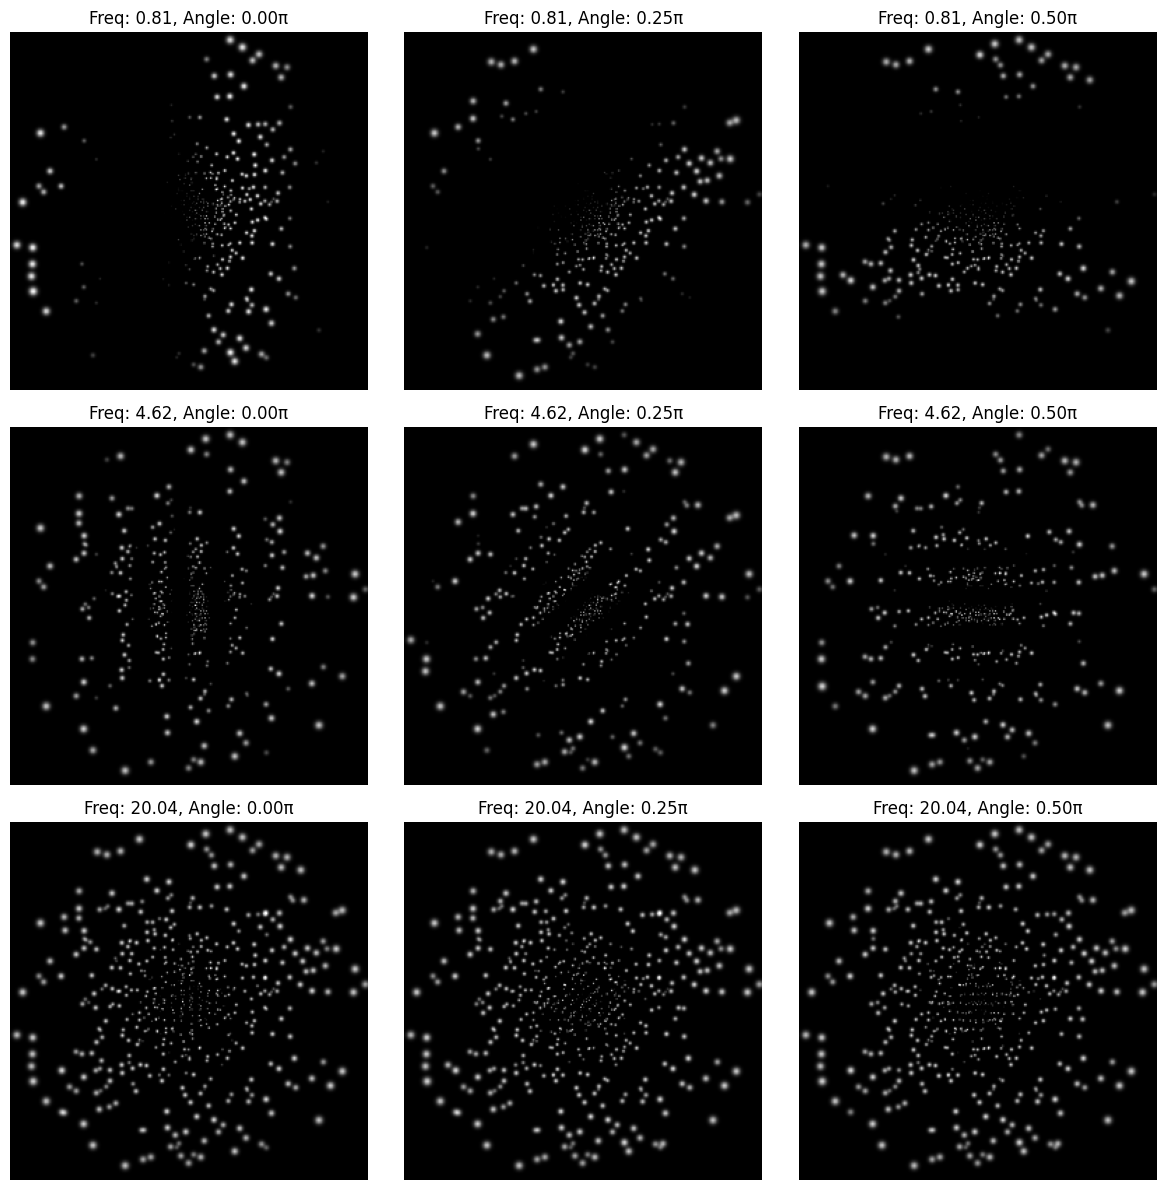

In [27]:
def generate_sinusoidal_pattern(size, freq, angle):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    wave = np.sin(2 * np.pi * freq * (X * np.cos(angle) + Y * np.sin(angle)))
    return (wave + 1) / 2  # Normalize to [0, 1]

# given the min_max_frequency, mean_max_frequency and max_max_frequency generate the sinusoidal pattern for a couple of angles and the phosphene image and show side by side

frequencies = [min_max_frequency, mean_max_frequency, max_max_frequency]
angles = [0, np.pi/4, np.pi/2]
size = 256
patterns = []

for freq in frequencies:
    for angle in angles:
        pattern = generate_sinusoidal_pattern(size, freq, angle)
        patterns.append(pattern)

phosphene_images = []
for pattern in patterns:
    stimulus = torch.tensor(pattern).float().cuda()
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*stim_weights)
    phosphene_images.append(phosphenes)

# show all phosphene images
plt.figure(figsize=(12,12))

for i, phos_image in enumerate(phosphene_images):
    plt.subplot(3,3,i+1)
    plt.imshow(phos_image.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Freq: {frequencies[i//3]:.2f}, Angle: {angles[i%3]/np.pi:.2f}π")

plt.tight_layout()
plt.show()

In [28]:
def laplacian_of_gaussian_fov(image, kernel_size=5, sigma_fov=1.0, fov=16, image_size=256):
    """
    Apply a Laplacian of Gaussian (LoG) filter to an image, with sigma defined in field-of-view space.

    Parameters:
        image (ndarray): Input image (grayscale).
        kernel_size (int): Size of the Gaussian kernel (odd number).
        sigma_fov (float): Standard deviation of the Gaussian in field-of-view units.
        fov (float): Total field of view in degrees.
        image_size (int): Size of the image in pixels (assumes square image).

    Returns:
        ndarray: Image filtered with the LoG filter.
    """
    # Convert sigma from field-of-view space to pixel space
    sigma_pixels = sigma_fov * (image_size / fov)

    # Create Laplacian of Gaussian kernel
    y, x = np.meshgrid(np.arange(-kernel_size//2 + 1, kernel_size//2 + 1),
                       np.arange(-kernel_size//2 + 1, kernel_size//2 + 1))
    laplacian = -(1/(np.pi * sigma_pixels**4)) * (1 - (x**2 + y**2) / (2 * sigma_pixels**2)) * \
                np.exp(-(x**2 + y**2) / (2 * sigma_pixels**2))
    
    # Normalize the LoG kernel
    laplacian -= laplacian.mean()

    # Apply the LoG filter
    filtered_image = cv2.filter2D(image, -1, laplacian)
    return filtered_image

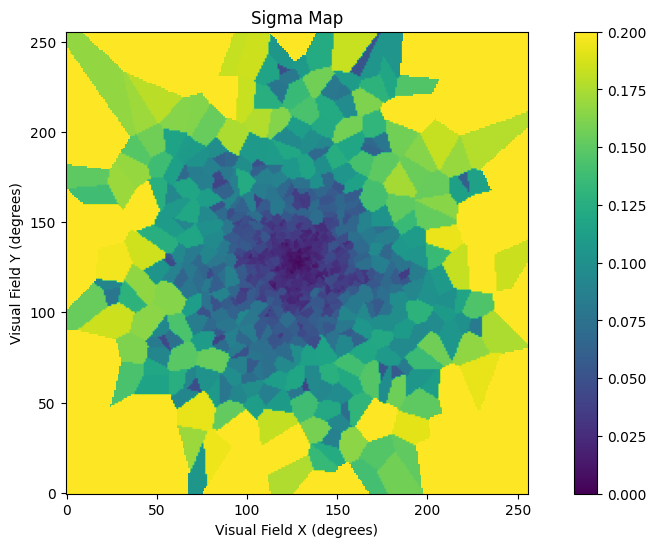

In [29]:
def compute_sigma_map(max_frequency_map):
    """
    Convert the max frequency map to a sigma map.
    """
    return 1 / (2 * np.pi * np.clip(max_frequency_map, 1e-3, None))  # Avoid division by zero

# Compute the sigma map
sigma_map = compute_sigma_map(max_frequencies_map_2d)

# show
plt.figure(figsize=(12,6))

plt.imshow(sigma_map, cmap='viridis', vmin=0, vmax=0.2)
plt.colorbar()
plt.title("Sigma Map")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()
plt.show()

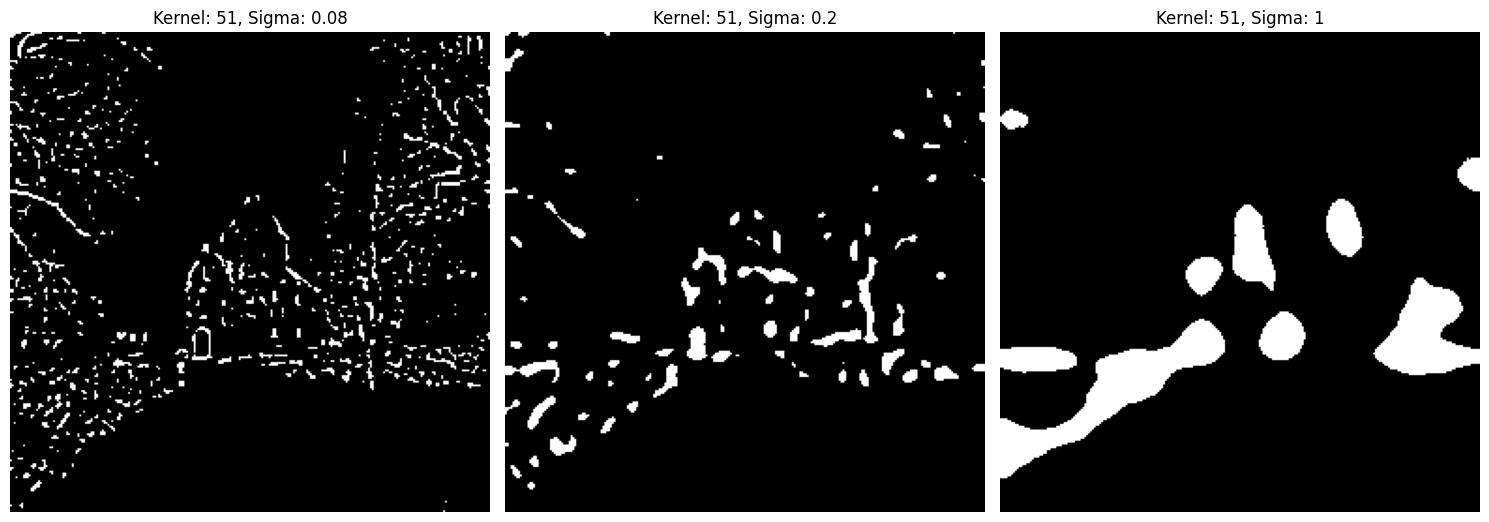

In [30]:
# Apply LoG filters with different parameters
kernel_sizes = [51]
sigmas = [0.08, 0.2, 1]
filtered_images = []

for kernel_size in kernel_sizes:
    for sigma in sigmas:
        filtered_image = laplacian_of_gaussian_fov(image, kernel_size=kernel_size, sigma_fov=sigma)
        # normalize
        filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
        # filtered_image = np.abs(filtered_image)
        filtered_image = filtered_image > 0.7
        filtered_images.append((filtered_image, kernel_size, sigma))

# Plot results
plt.figure(figsize=(15, 10))
for i, (filtered_image, kernel_size, sigma) in enumerate(filtered_images):
    plt.subplot(len(kernel_sizes), len(sigmas), i + 1)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f"Kernel: {kernel_size}, Sigma: {sigma}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
# interactive plot for the LoG filter: kernel_size, sigma, weighted

def plot_log_filter(kernel_size=51, sigma=0.2, threshold=0.6, weighted=True):
    filtered_image = laplacian_of_gaussian_fov(foveated_image, kernel_size=kernel_size, sigma_fov=sigma)
    filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
    filtered_image = filtered_image > threshold
    
    # phosphene image 
    simulator.reset()
    stimulus = simulator.sample_stimulus(torch.tensor(filtered_image).float().cuda(), rescale=True)
    if weighted:
        stimulus = stimulus*stim_weights
    phosphenes = simulator(stimulus)

    plt.figure(figsize=(21,15))

    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title("Filtered Image")

    plt.subplot(1,3,3)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_log_filter, kernel_size=(3, 99, 2), sigma=(0.01, 2, 0.01), threshold=(0, 1, 0.01),
             weighted=True)

interactive(children=(IntSlider(value=51, description='kernel_size', max=99, min=3, step=2), FloatSlider(value…

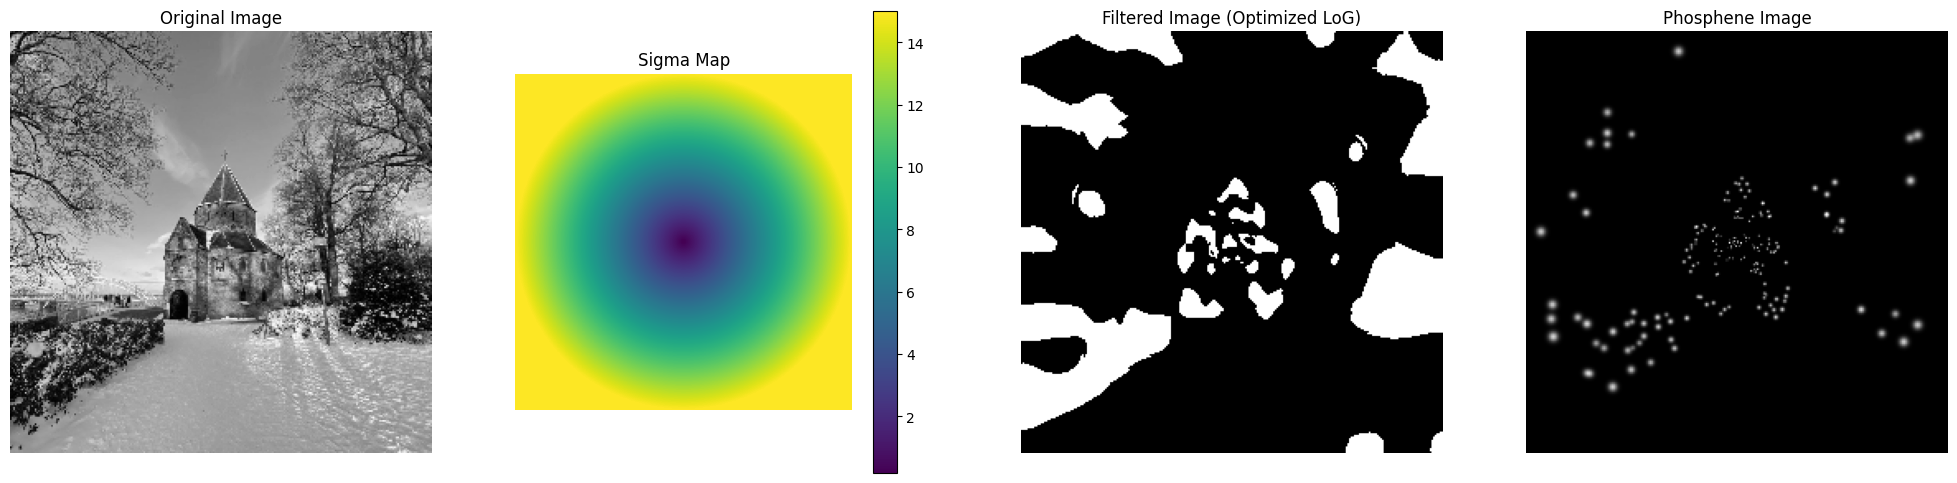

In [32]:
def generate_log_kernel(kernel_size, sigma):
    """
    Generate a Laplacian of Gaussian (LoG) kernel.
    """
    y, x = np.meshgrid(np.arange(-kernel_size//2 + 1, kernel_size//2 + 1),
                       np.arange(-kernel_size//2 + 1, kernel_size//2 + 1))
    log_kernel = -(1/(np.pi * sigma**4)) * (1 - (x**2 + y**2) / (2 * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    log_kernel -= log_kernel.mean()  # Normalize
    return log_kernel

def create_sigma_map(image_size, min_sigma, max_sigma, view_angle):
    """
    Generate a sigma map based on eccentricity from the center.
    """
    max_eccentricity = view_angle / 2
    x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
    y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt(xx**2 + yy**2)
    
    # Map eccentricity to sigma
    sigma_map = np.interp(r, [0, max_eccentricity], [min_sigma, max_sigma])
    return sigma_map

def optimized_log_filter(image, sigma_map, kernel_size, num_bins, min_sigma, max_sigma):
    """
    Apply an optimized LoG filter using precomputed kernels.
    """
    # Precompute LoG kernels
    sigma_bins = np.linspace(min_sigma, max_sigma, num_bins)
    log_kernels = [generate_log_kernel(kernel_size, sigma) for sigma in sigma_bins]
    
    # Discretize the sigma map
    sigma_indices = np.digitize(sigma_map, sigma_bins, right=True)
    
    # Initialize filtered image
    filtered_image = np.zeros_like(image, dtype=np.float32)
    
    # Apply each kernel to its corresponding region
    for i, kernel in enumerate(log_kernels):
        mask = (sigma_indices == i).astype(np.uint8)
        convolved = cv2.filter2D(image, -1, kernel)
        # Normalize the convolved image
        # print(convolved.min(), convolved.max())
        convolved = (convolved - convolved.min()) / (convolved.max() - convolved.min())-0.5
        filtered_image += convolved * mask  # Add contribution from this kernel
    
    return filtered_image

# Parameters
image_size = 256
view_angle = 16  # Degrees
min_sigma = 0.1
max_sigma = 15
kernel_size = 61  # Kernel size for LoG
num_bins = 10  # Number of sigma bins

# Create the sigma map
sigma_map = create_sigma_map(image_size, min_sigma, max_sigma, view_angle)

# Apply optimized LoG filter
filtered_image = optimized_log_filter(image, sigma_map, kernel_size, num_bins, min_sigma, max_sigma)
# filtered_image = np.abs(filtered_image)
# print(filtered_image.min(), filtered_image.max())
# clip the values, everything under 0 is 0, everything over 0.3 is 0.3
# filtered_image = np.clip(filtered_image, 0, 0.2)

filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
filtered_image = filtered_image > 0.6

# phosphene
simulator.reset()
stimulus = simulator.sample_stimulus(torch.tensor(filtered_image).float().cuda(), rescale=True)
stimulus = stimulus*stim_weights
phosphenes = simulator(stimulus)

# Visualization
plt.figure(figsize=(25, 6))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# sigma map
plt.subplot(1, 4, 2)
plt.imshow(sigma_map, cmap='viridis')
plt.title("Sigma Map")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title("Filtered Image (Optimized LoG)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.title("Phosphene Image")
plt.axis("off")
plt.show()

In [33]:
# interactive plot for the optimized LoG filter: kernel_size, num_bins, min_sigma, max_sigma, threshold, weighted

def plot_optimized_log_filter(kernel_size=77, num_bins=15, min_sigma=0.3, max_sigma=16, threshold=0.6, weighted=True):
    # Create the sigma map
    sigma_map = create_sigma_map(image_size, min_sigma, max_sigma, view_angle)

    # Apply optimized LoG filter
    filtered_image = optimized_log_filter(image, sigma_map, kernel_size, num_bins, min_sigma, max_sigma)
    filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
    filtered_image = filtered_image > threshold

    # phosphene image 
    simulator.reset()
    stimulus = simulator.sample_stimulus(torch.tensor(filtered_image).float().cuda(), rescale=True)
    if weighted:
        stimulus = stimulus*stim_weights
    phosphenes = simulator(stimulus)

    plt.figure(figsize=(21,15))

    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title("Filtered Image")

    plt.subplot(1,3,3)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_optimized_log_filter, kernel_size=(3, 99, 2), num_bins=(5, 50, 1), min_sigma=(0.001, 1, 0.001), max_sigma=(1, 20, 0.1), threshold=(0, 1, 0.01), weighted=True)

interactive(children=(IntSlider(value=77, description='kernel_size', max=99, min=3, step=2), IntSlider(value=1…

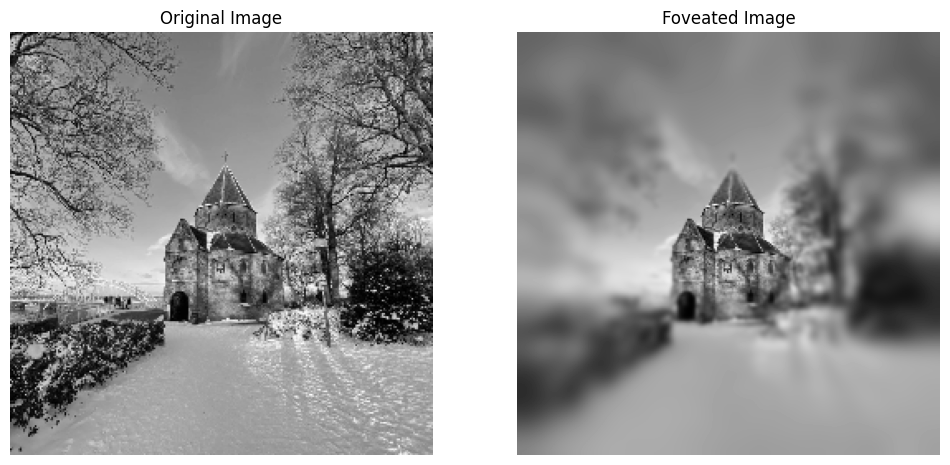

In [34]:
# open image valkhof.jpg

# Load the image
image = cv2.imread('valkhof.jpg', cv2.IMREAD_GRAYSCALE)
# crop image to be square
# get the dimensions
h, w = image.shape
# calculate the crop size
crop_size = min(h, w)
# calculate the starting point
start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
# crop the image
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

in_channels = 1
out_channels = 1
kernel_size = 1
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='gaussian_modulated',
                    gaussian_kernel_size=51, sigma_min=0.0001, sigma_max=15, sigma_function='exponential', contrast_factor=1, padding_mode='reflect').cuda()

# center of the image foa_xy
foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)
torch_image = torch.tensor(image).float().cuda().unsqueeze(0).unsqueeze(0)
out = net(torch_image, foa_xy)

foveated_image = out[0][0].detach().cpu().numpy()
# normalize between 0 and 1 
foveated_image = (foveated_image - foveated_image.min()) / (foveated_image.max() - foveated_image.min())

# Show the foveated image
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(foveated_image, cmap='gray')
plt.axis('off')
plt.title("Foveated Image")

plt.show()


In [35]:
def laplacian_of_gaussian(image, sigma=1.0, image_size=256):
    """
    Apply a Laplacian of Gaussian (LoG) filter to an image, with sigma defined in field-of-view space.

    Parameters:
        image (ndarray): Input image (grayscale).
        kernel_size (int): Size of the Gaussian kernel (odd number).
        sigma_fov (float): Standard deviation of the Gaussian in field-of-view units.
        fov (float): Total field of view in degrees.
        image_size (int): Size of the image in pixels (assumes square image).

    Returns:
        ndarray: Image filtered with the LoG filter.
    """
    # calculate kernel size
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)


    # Create Laplacian of Gaussian kernel
    y, x = np.meshgrid(np.arange(-kernel_size//2 + 1, kernel_size//2 + 1),
                       np.arange(-kernel_size//2 + 1, kernel_size//2 + 1))
    laplacian = -(1/(np.pi * sigma**4)) * (1 - (x**2 + y**2) / (2 * sigma**2)) * \
                np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Normalize the LoG kernel
    laplacian -= laplacian.mean()

    # Apply the LoG filter
    filtered_image = cv2.filter2D(image, -1, laplacian, borderType=cv2.BORDER_REFLECT)
    return filtered_image

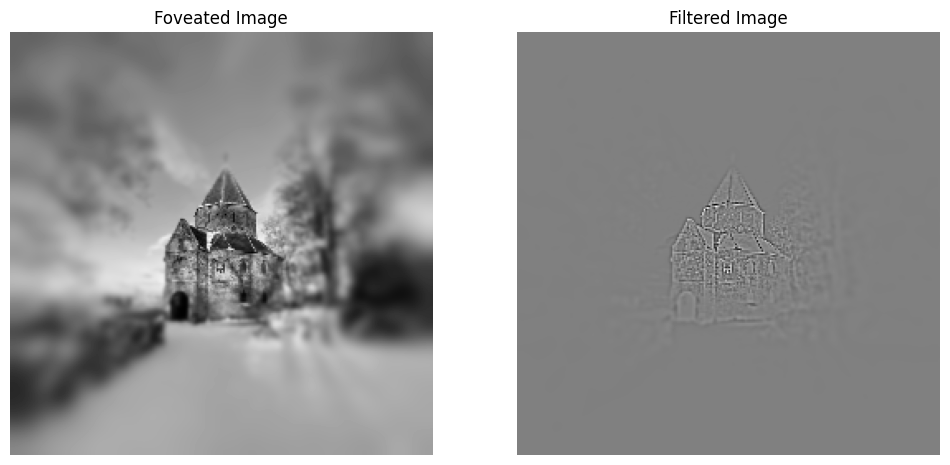

In [36]:
in_channels = 1
out_channels = 1
kernel_size = 1
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='gaussian_modulated', gaussian_kernel_size=51, sigma_min=0.1, sigma_max=12, sigma_function='exponential', contrast_factor=1).cuda()

# center of the image foa_xy
foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)
torch_image = torch.tensor(image).float().cuda().unsqueeze(0).unsqueeze(0)

out = net(torch_image, foa_xy)

foveated_image = out[0][0].detach().cpu().numpy()
foveated_image = (foveated_image - foveated_image.min()) / (foveated_image.max() - foveated_image.min())

# apply laplacian_of_gaussian_fov
filtered_image = laplacian_of_gaussian(foveated_image, sigma=0.1)
filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())

# show the foveated image and the filtered image
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(foveated_image, cmap='gray')
plt.axis('off')
plt.title("Foveated Image")

plt.subplot(1,2,2)
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.title("Filtered Image")

plt.show()

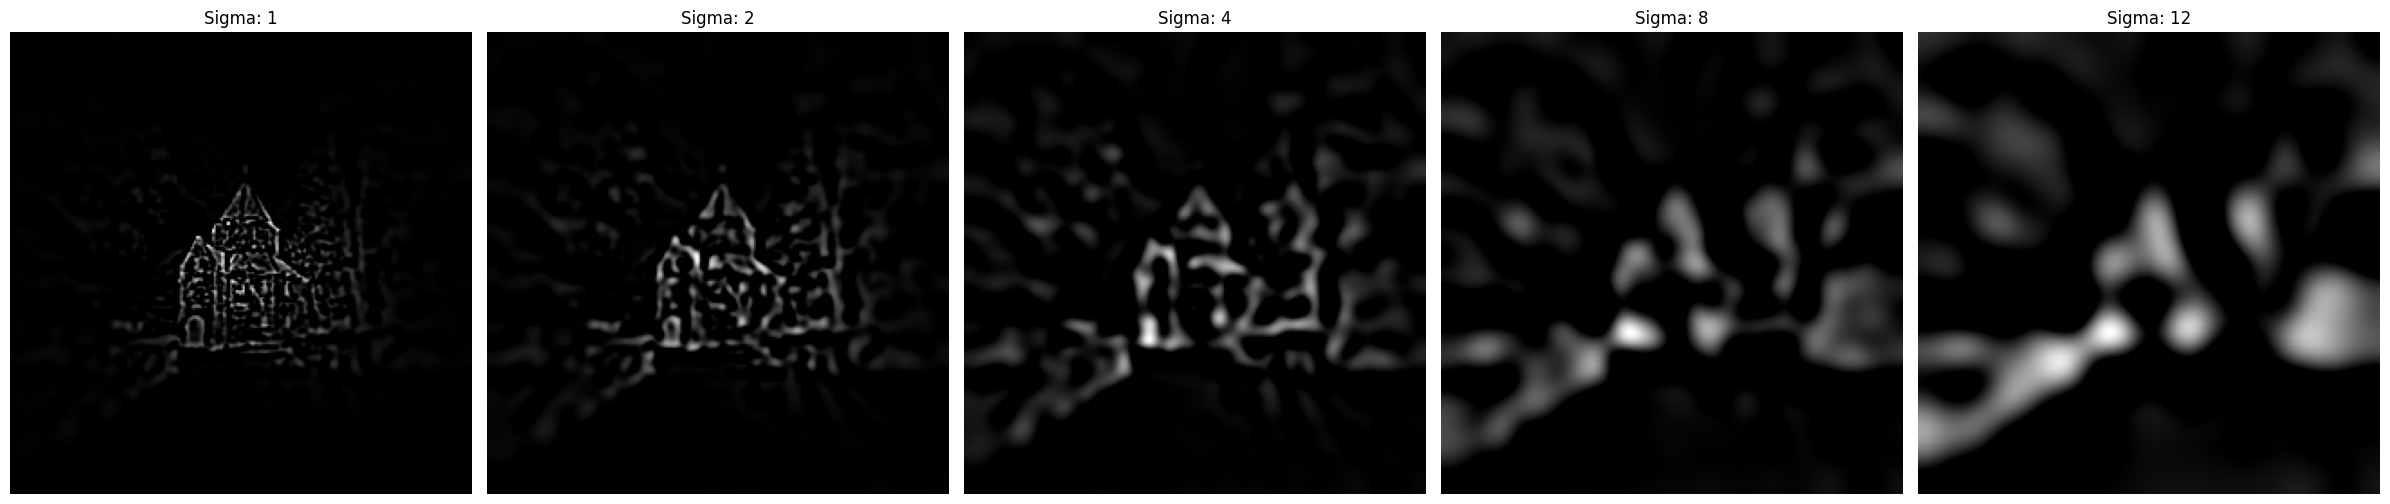

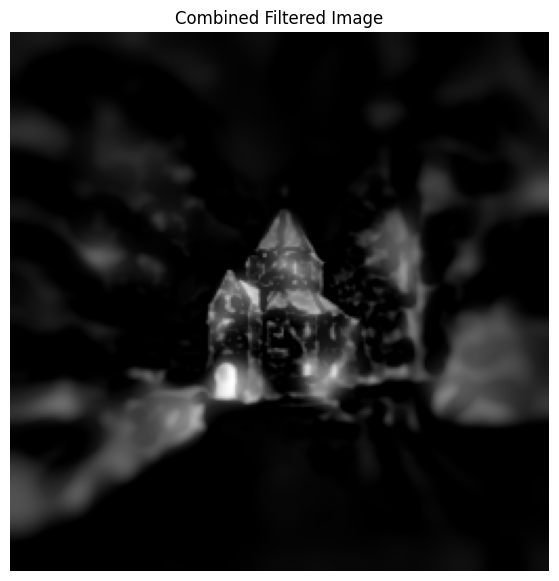

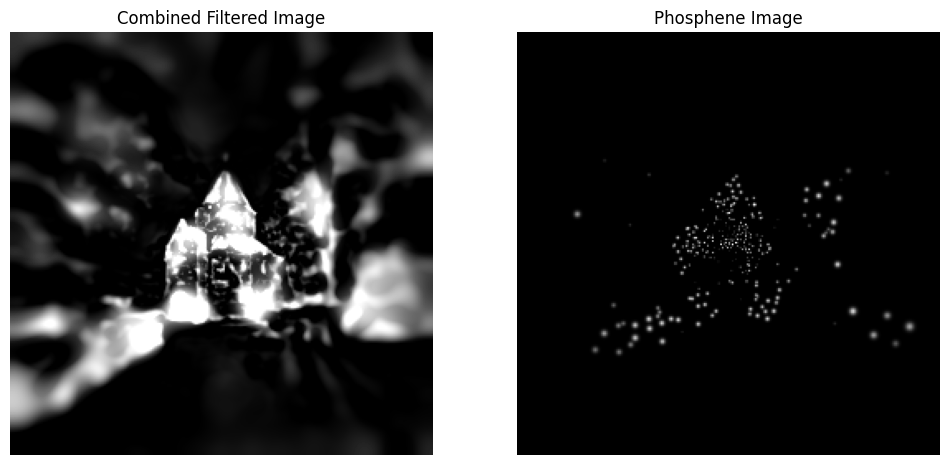

In [37]:
sigmas = [1, 2, 4, 8, 12]
filtered_images = []

for sigma in sigmas:
    filtered_image = laplacian_of_gaussian(foveated_image, sigma=sigma)
    # clip at 0
    filtered_image = np.clip(filtered_image, 0, None)
    filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
    filtered_images.append(filtered_image)

# show all filtered images
plt.figure(figsize=(24,12))

for i, filtered_image in enumerate(filtered_images):
    plt.subplot(1,len(sigmas),i+1)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Sigma: {sigmas[i]}")

plt.tight_layout()
plt.show()

# add them together
combined_filtered_image = np.zeros_like(filtered_images[0])

for filtered_image in filtered_images:
    combined_filtered_image += filtered_image

combined_filtered_image = (combined_filtered_image - combined_filtered_image.min()) / (combined_filtered_image.max() - combined_filtered_image.min()) 

# show the combined filtered image
plt.figure(figsize=(12,7))

plt.imshow(combined_filtered_image, cmap='gray')
plt.axis('off')
plt.title("Combined Filtered Image")

plt.show()

# clip combined_filtered_image
# combined_filtered_image = np.clip(combined_filtered_image, 0, 0.5)
# normalize
combined_filtered_image = (combined_filtered_image - combined_filtered_image.min()) / (combined_filtered_image.max() - combined_filtered_image.min())
# clip then normalize
combined_filtered_image = np.clip(combined_filtered_image, 0, 0.4)
combined_filtered_image = (combined_filtered_image - combined_filtered_image.min()) / (combined_filtered_image.max() - combined_filtered_image.min())

# use combined_filtered_image for phosphene image
simulator.reset()
stimulus = simulator.sample_stimulus(torch.tensor(combined_filtered_image).float().cuda(), rescale=True)
stimulus = stimulus*stim_weights
phosphenes = simulator(stimulus)

# show the phosphene image
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(combined_filtered_image, cmap='gray')
plt.axis('off')
plt.title("Combined Filtered Image")

plt.subplot(1,2,2)
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

In [38]:
# import SelectMultiple
from ipywidgets import SelectMultiple

# interactive plot for the stacked LoG filter: sigmas, foveation sigmas, clipping, weighted
# show the input image, the foveated image, the combined filtered image and the phosphene image
# instead of thresholding we do now clipping between 0 and some value between 0 and 1

def plot_stacked_log_filter(sigmas=[1, 2, 4, 8, 12, 15], fov_sigma_min=1, fov_sigma_max=15, clipping=0.4, weighted=True):
    # apply the foveated image
    in_channels = 1
    out_channels = 1
    kernel_size = 1
    net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='gaussian_modulated',
                        gaussian_kernel_size=51, sigma_min=fov_sigma_min, sigma_max=fov_sigma_max, sigma_function='exponential', contrast_factor=1, padding_mode="reflect").cuda()

    # center of the image foa_xy
    foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)
    torch_image = torch.tensor(image).float().cuda().unsqueeze(0).unsqueeze(0)

    out = net(torch_image, foa_xy)

    foveated_image = out[0][0].detach().cpu().numpy()
    foveated_image = (foveated_image - foveated_image.min()) / (foveated_image.max() - foveated_image.min())

    # apply the LoG filters
    filtered_images = []

    for sigma in sigmas:
        filtered_image = laplacian_of_gaussian(foveated_image, sigma=sigma)
        filtered_image = np.clip(filtered_image, 0, clipping)
        filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
        filtered_images.append(filtered_image)

    # add them together
    combined_filtered_image = np.zeros_like(filtered_images[0])

    for filtered_image in filtered_images:
        combined_filtered_image += filtered_image

    combined_filtered_image = (combined_filtered_image - combined_filtered_image.min()) / (combined_filtered_image.max() - combined_filtered_image.min()) 
    combined_filtered_image = np.clip(combined_filtered_image, 0, clipping)
    combined_filtered_image = (combined_filtered_image - combined_filtered_image.min()) / (combined_filtered_image.max() - combined_filtered_image.min()) 

    # phosphene
    simulator.reset()
    stimulus = simulator.sample_stimulus(torch.tensor(combined_filtered_image).float().cuda(), rescale=True)
    if weighted:
        stimulus = stimulus*stim_weights
    phosphenes = simulator(stimulus)

    # Visualization
    plt.figure(figsize=(21,15))

    plt.subplot(1,4,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Image")

    plt.subplot(1,4,2)
    plt.imshow(foveated_image, cmap='gray')
    plt.axis('off')
    plt.title("Foveated Image")

    plt.subplot(1,4,3)

    plt.imshow(combined_filtered_image, cmap='gray')
    plt.axis('off')
    plt.title("Combined Filtered Image")

    plt.subplot(1,4,4)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_stacked_log_filter, sigmas=SelectMultiple(options=[1, 2, 4, 8, 12, 15], value=[1, 2, 4, 8, 12, 15]), fov_sigma_min=(0.1, 20, 0.1), fov_sigma_max=(1, 20, 0.1), clipping=(0.01, 1, 0.01), weighted=True)

interactive(children=(SelectMultiple(description='sigmas', index=(0, 1, 2, 3, 4, 5), options=(1, 2, 4, 8, 12, …